# DivP Analysis MOCK repertoires

# Packages

In [1]:
from os import listdir
from os.path import isfile, join
import os
import re
import pandas as pd
from collections import defaultdict
from collections import OrderedDict
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import decomposition
from sklearn.metrics import accuracy_score

In [2]:
def plt_divP(divP_df, sample_name, distance_int, wdir_path): 
    divP_df_long = pd.melt(divP_df, "q", var_name = "Lambda", value_name = "DqZ")
    qs_label = [q if q != "7" else "$\infty$" for q in list(map(str, divP_df["q"]))]
    plt.figure(figsize=(6,8))
    ax =sns.lineplot(x="q", y="DqZ", data=divP_df_long, hue = "Lambda", markers=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.fill_between(divP_df["q"].values, divP_df["16.0"].values, divP_df["identity"].values, 
                 facecolor='red', alpha = 0.2)
    
    plt.xticks(ticks = divP_df["q"].values, labels = qs_label, fontsize = 13)
    plt.yticks(ticks = range(0,13), fontsize = 13)
    plt.ylim(top=12)
    plt.xlabel("q", fontsize = 20)
    plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
    plt.title(sample_name, fontsize = 20)
    plt.savefig(wdir_path + "divPs/"+ sample_name + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
    return plt

In [3]:
def calculate_area_between_curves(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas.reverse()
    area_dict = OrderedDict()
    for index,first in list(enumerate(lambdas)):
        for second in lambdas[index+1:]:
            area = np.trapz(divP_df[first].values , x=divP_df["q"].values) - np.trapz(divP_df[second].values , x=divP_df["q"].values)
            area_dict["_".join([first, second, "area"])] = area
    return area_dict



In [4]:
def calculate_slopes(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas = [lb for lb in lambdas if lb != "0.0"]
    lambdas.reverse()
    slope_dict = OrderedDict()
    for lb in lambdas: 
        slope_dict["_".join(["0_1_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[1, lb]
        slope_dict["_".join(["0_2_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[2, lb]
        slope_dict["_".join(["1_2_slope", lb])] = divP_df.loc[1, lb]-divP_df.loc[2, lb]
    return slope_dict

In [5]:
def calculate_avg_delta_lambda_05_00(divP_df):
    avg_delta_lambda = divP_df[["0.0","0.1","0.2", "0.3", "0.4", "0.5"]].diff(axis = 1).mean().mean()
    return avg_delta_lambda

In [6]:
def make_divP_one_row_df(divP_df):
    divP_df_wo_L0 = divP_df.drop("0.0", axis = 1)
    list_of_lambdas = [lmbd for lmbd in list(divP_df_wo_L0) if lmbd != "q"]
    list_of_dqz = list()
    for lmbd in list_of_lambdas:
        for qu in divP_df_wo_L0["q"]:
            if qu == 7: 
                qu = 11
                qu_name = "infinity"
            qu_name = str(qu)
            list_of_dqz.append(("L_"+ lmbd + "_q_" +qu_name, divP_df_wo_L0.loc[qu,lmbd]))
    sample_dqz = pd.DataFrame(list_of_dqz).T
    sample_dqz.columns = sample_dqz.iloc[0]
    sample_dqz = sample_dqz.drop(sample_dqz.index[0])
    sample_dqz = sample_dqz.reset_index(drop = "True")
    return sample_dqz



In [7]:
# Path to working dir: 
wdir_path = "/Users/milvu/Documents/OneDrive - Danmarks Tekniske Universitet/TCR_analysis/TCRDivER_algorithm/datasets_divP_calculated/"


Let's make the metadata dataframe from the filenames themselves by establishing some criteria. 

# Mock repertoires **EVEN** frequencies divPs 
Each mock repertoire consists of 100 CDR3s with the same intra repertoire distance.

The distances in the repertoires are: 

    * Repertoire I: d = 5.000000000000000278e-02
    * Repertoire II: d = 1.000000000000000056e-01
    * Repertoire III: d = 5.000000000000000000e-01
    
The CDR3 frequencies of all the repertoires are the same and equal to 1/100. The repertoires are uniform. 

In [8]:
# load filenames: 
folder_name = "mock_repertoires/"
divP_fpath = wdir_path +  folder_name + "divP_tsv/"
divP_files = [f for f in listdir(divP_fpath) if isfile(join(divP_fpath, f))]
divP_files = [f for f in divP_files if f.endswith('tsv')]
divP_files = [re.sub('\.tsv$', '', f) for f in divP_files]
divP_files.sort()
divP_files = [f for f in divP_files]

divP_files

['d1_divP', 'd2_divP', 'd3_divP']

In [9]:
sample_names_dist_dict = {"d1": "0.05", "d2": "0.1", "d3": "0.5"}

In [10]:
repertoire_names_dict = {"d1": "I", "d2": "II", "d3": "III"}

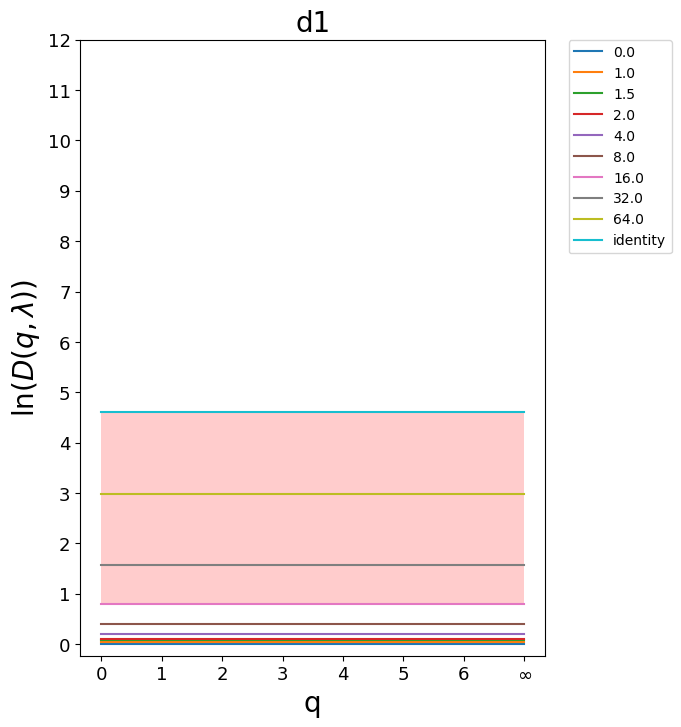

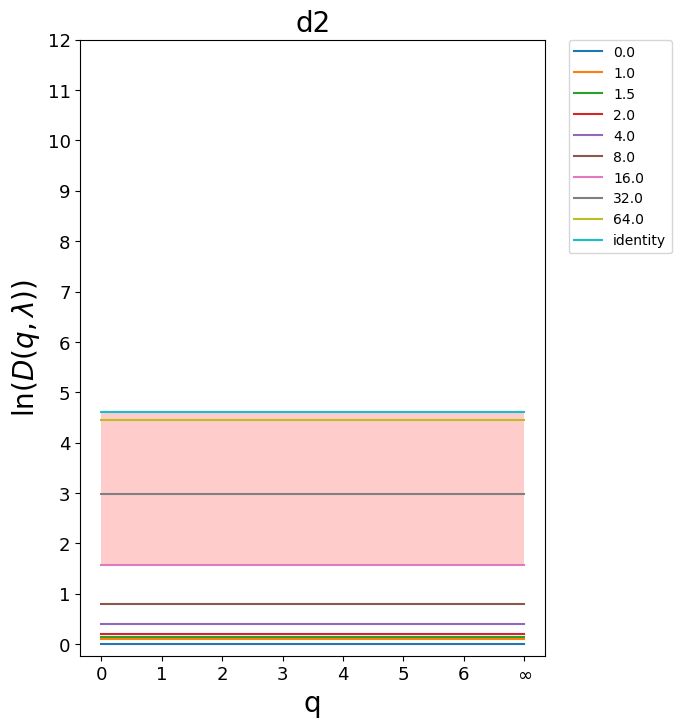

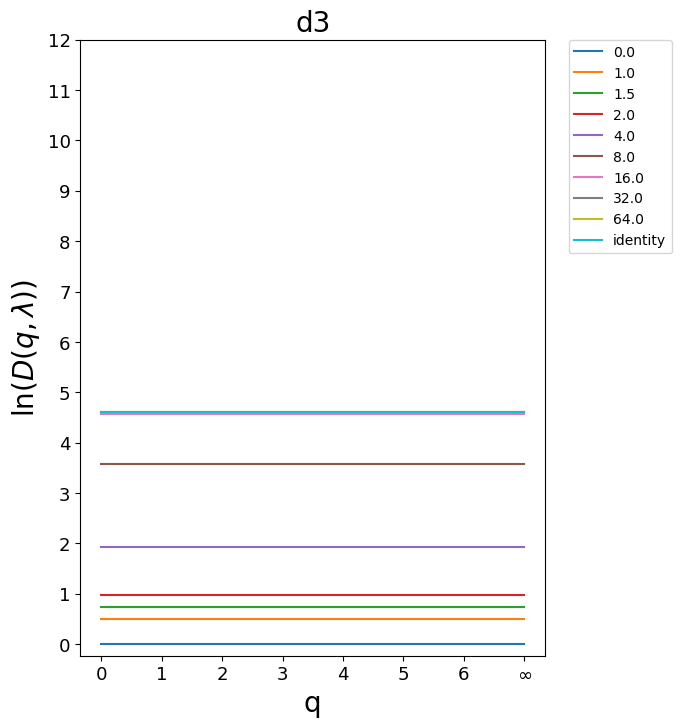

In [11]:
# define divP files 
divP_fpath = wdir_path +  folder_name + "divP_tsv/"
# Initiate empty list to store area dictionaries 
divP_areas = []
divP_slopes = []
average_delta_lambda = []
divP1_all_list = []
samples_list = []
# iterate trough files 
for sample_name in sample_names_dist_dict.keys():
    divP_df = pd.read_csv(divP_fpath + sample_name+ "_divP.tsv", comment='#', sep = '\t')
    divP_df = divP_df.set_index('q')
    divP_df.insert(0, '0.0', [1]*divP_df.shape[0])
    #ln transform the dataframe
    divP_df = np.log(divP_df)
    qs = divP_df.index.values[:-1]
    qs = np.append(qs, (divP_df.index.values[-2] + 1))
    divP_df["q"] = qs
    #calculate areas dictionary and append to a list
    divP_areas.append(calculate_area_between_curves(divP_df))
    #calculate slopes dictionary and append to a list
    divP_slopes.append(calculate_slopes(divP_df))
    ##calculate average delta lambda for small lambda: 
    average_delta_lambda.append(calculate_avg_delta_lambda_05_00(divP_df))
    #convert divP into a row df and append to a list: 
    divP1_all_list.append(make_divP_one_row_df(divP_df))
    #plot divPs
    divP_df = divP_df.drop(["0.1", "0.2", "0.25", "0.3", "0.4", "0.5", "0.75"], axis =1 )
    plt_divP(divP_df, sample_name, sample_names_dist_dict[sample_name], wdir_path +  folder_name)
    #append sample name: 
    samples_list.append(sample_name)
    
divP_areas_df = pd.DataFrame.from_dict(divP_areas)
divP_slopes_df = pd.DataFrame.from_dict(divP_slopes)
average_delta_lambda_df = pd.DataFrame(average_delta_lambda, columns = ["Average area for small lambdas"])
divP1_all_df = pd.concat(divP1_all_list)
divP1_all_df = divP1_all_df.reset_index(drop = "True")


divP_features = pd.concat([divP_areas_df, 
                           divP_slopes_df,
                           average_delta_lambda_df], axis=1)

divP_features["Sample name"] = samples_list
divP_features["Repertoire"] = [repertoire_names_dict[sample] for sample in samples_list]

In [12]:
divP_features

,identity_64.0_area,identity_32.0_area,identity_16.0_area,identity_8.0_area,identity_4.0_area,identity_2.0_area,identity_1.5_area,identity_1.0_area,identity_0.75_area,identity_0.5_area,...,1_2_slope_0.25,0_1_slope_0.2,0_2_slope_0.2,1_2_slope_0.2,0_1_slope_0.1,0_2_slope_0.1,1_2_slope_0.1,Average area for small lambdas,Sample name,Repertoire
0,1.131553e+01,21.307574,26.721458,29.470535,30.851672,31.543549,31.716641,31.889779,31.976366,32.062963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004949,d1,I
1,1.066008e+00,11.315532,21.307574,26.721458,29.470535,30.851672,31.197511,31.543549,31.716641,31.889779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009897,d2,II
2,7.005951e-12,0.000078,0.228699,7.240378,18.669719,25.355449,27.063948,28.781455,29.642968,30.506045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049433,d3,III


### Lineplot of areas and slope 


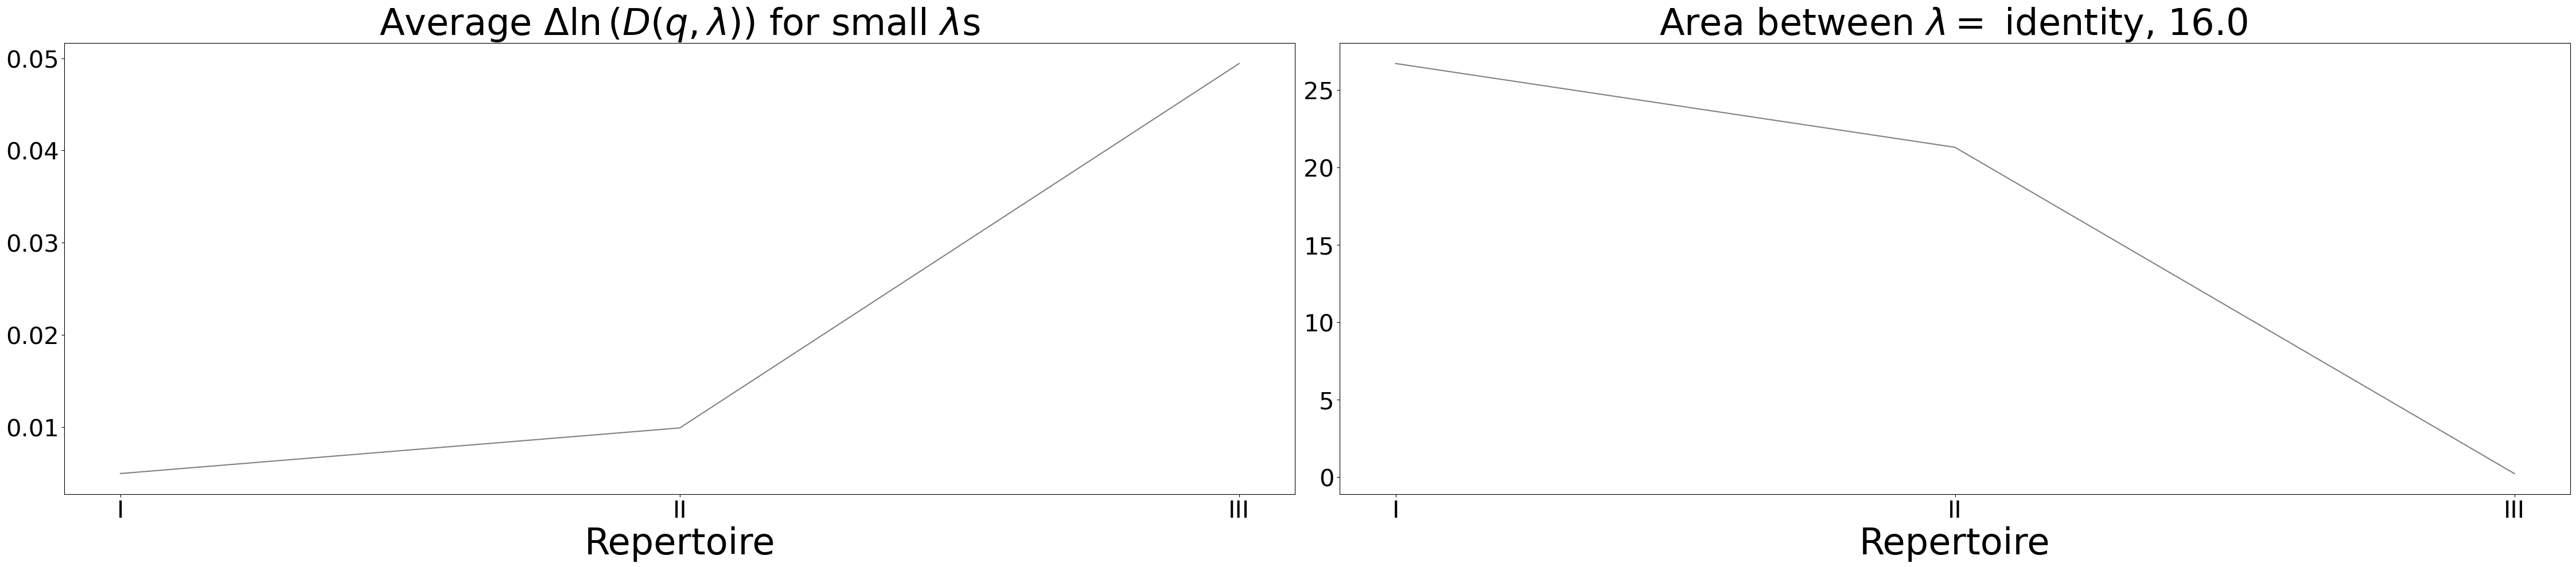

In [13]:
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)
plt.rc('axes', labelsize=46) 

fig, ax = plt.subplots(1, 2, figsize=(45, 10), sharey=False, sharex = True)
p1 = sns.lineplot(x="Repertoire", y="Average area for small lambdas", data=divP_features, sort=False, ax=ax[0], color = "gray")
p2 = sns.lineplot(x="Repertoire", y="identity_16.0_area", data=divP_features, sort=False, ax=ax[1], color = "gray")
#p3 = sns.lineplot(x="Repertoire", y="0_1_slope_identity", data=divP_features, sort=False, ax=ax[2], color = "blue")

ax[0].set_ylabel('')
ax[1].set_ylabel('')
#ax[2].set_ylabel('')

ax[0].set_xlabel('Repertoire')
ax[1].set_xlabel('Repertoire')
#ax[2].set_xlabel('Repertoire')

p1.set_title('Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s', fontsize = 46)
p2.set_title('Area between $\lambda =$ identity, 16.0 ', fontsize = 46)
#p3.set_title('Slope between q = 0, 1 for $\lambda =$ identity', fontsize = 46)

#plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=-45, ha="left")
#plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=-45, ha="left")
#plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=-45, ha="left")

plt.tight_layout()

plt.savefig(wdir_path +  folder_name +"lineplot_areas_slope.pdf")